<a href="https://colab.research.google.com/github/arturops/ai-notebooks/blob/main/text_clustering_and_topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Clustering

A common pipeline to do text clustering that has gained popularity involves three steps and algorithms:

1. Convert the input documents to embeddings with an embedding model.

2. Reduce the dimensionality of embeddings with a dimensionality reduction model.

3. Find groups of semantically similar documents with a cluster model.

## Imports, pip installs and loading dataset

In [5]:
!pip install hdbscan umap-learn datasets sentence_transformers

In [6]:
# For topic modeling (require also all text clustering packages)
!pip install bertopic

In [4]:
# for visualizing the final topics nicely
!pip install datamapplot==0.3.0

In [7]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer

In [8]:
# Load data from Hugging Face -  use arxiv papers dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]

# Extract metadata
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [9]:
dataset[0:5]

{'Titles': ['Introduction to Arabic Speech Recognition Using CMUSphinx System',
  'Arabic Speech Recognition System using CMU-Sphinx4',
  'On the Development of Text Input Method - Lessons Learned',
  'Network statistics on early English Syntax: Structural criteria',
  'Segmentation and Context of Literary and Musical Sequences'],
 'Abstracts': ['  In this paper Arabic was investigated from the speech recognition problem\npoint of view. We propose a novel approach to build an Arabic Automated Speech\nRecognition System (ASR). This system is based on the open source CMU Sphinx-4,\nfrom the Carnegie Mellon University. CMU Sphinx is a large-vocabulary;\nspeaker-independent, continuous speech recognition system based on discrete\nHidden Markov Models (HMMs). We build a model using utilities from the\nOpenSource CMU Sphinx. We will demonstrate the possible adaptability of this\nsystem to Arabic voice recognition.\n',
  '  In this paper we present the creation of an Arabic version of Automat

## 1. Converting data into embeddings

In [10]:
# download the embedding model from hugging face
embedding_model = SentenceTransformer("thenlper/gte-small")

# Create an embedding for each abstract
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

# the resulting embedding dimension depends on the model and dataset so check it
embeddings.shape

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

(44949, 384)

## 2. Reducing dimensions of embeddings

We will use UMAP as it tends to handle nonlinear relationships and structures a bit better than PCA.

In [11]:
from umap import UMAP

# >> n_components - number of dimensions to reduce the model embeddings to.
# Values between 5 and 10 work well to capture global structures
# >> min_dist is the minimum distance between embedded points, this can
# result intighter clusters aka gives clustering an easier time to find
# unique clusters
# >> metric - cosine similarity
umap_model = UMAP(
    n_components=5, min_dist=0.0, metric='cosine', random_state=42
)

reduced_embeddings = umap_model.fit_transform(embeddings)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## 3. Cluster the reduced embeddings

We do not know the number of clusters beforehand, so K-Means is not a good choice for us. Instead we need a density-based algo that freely calculates the number of clusters. One such algo is HDBSCAN, and it also helps to find outliers which can be helpful to identify missing categories or very little samples that we have on our dataset.

In [12]:
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(
    min_cluster_size=50, metric="euclidean", cluster_selection_method="eom"
)
# fit the model with reduced embeddings to find clusters
hdbscan_model.fit(reduced_embeddings)

# retrieve the clusters
clusters = hdbscan_model.labels_

# show number of unique clusters found
print(f"Number of clusters found: {len(set(clusters))}")

Number of clusters found: 153


In [13]:
clusters

array([ -1, 126,  -1, ...,  -1, 129,  -1])

## Visualize the clusters

To visualize the clusters we need to be able to display them in a 2D (max 3D) plane, so we need to:

1. Apply once again UMAP to our embeddings to reduce them to 2D
2. Use the 2D embeddings and merge them with the identified cluster rows, to have a visualization

In [14]:
# reduced embeddings to 2D
umap_model_2d = UMAP(
    n_components=2, min_dist=0.0, metric="cosine", random_state=42
)
embeddings_2d = umap_model_2d.fit_transform(embeddings)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [15]:
import pandas as pd

# merge 2D embeddings with clusters found
df = pd.DataFrame(embeddings_2d, columns=["x", "y"])
df["title"] = titles
# assuming order is respected and nothing got shuffled!
df["cluster"] = [str(c) for c in clusters]


# select outliers and non-outliers (clusters)
non_outliers_df = df.loc[df['cluster'] != "=-1", :]
outliers_df = df.loc[df['cluster'] == "-1", :]

(-7.778345727920533,
 10.878833436965943,
 -1.711702972650528,
 16.388065367937088)

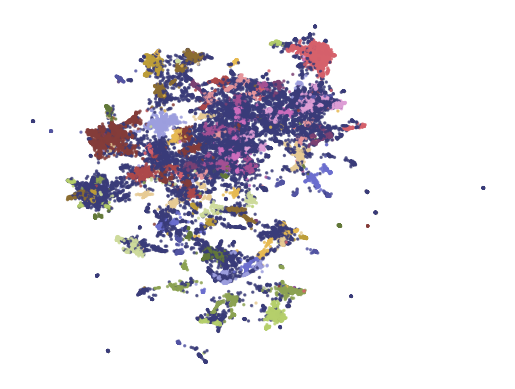

In [16]:
import matplotlib.pyplot as plt

# plot outliers
plt.scatter(outliers_df['x'], outliers_df['y'], alpha=0.1, s=2, c="grey")

# plot clusters
plt.scatter(
    non_outliers_df['x'],
    non_outliers_df['y'],
    c=non_outliers_df['cluster'].astype(int),
    alpha=0.7,
    s=2,
    cmap="tab20b"
)
plt.axis('off')

# Topic Modeling

Once we have the text clustering, we can try to identify the `topic` of a cluster. We use something called `BERTopic` to do this.

In [18]:
from bertopic import BERTopic

# Train our model with our previously defined models
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(abstracts, embeddings)


2024-12-03 10:35:35,755 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-03 10:36:37,064 - BERTopic - Dimensionality - Completed ✓
2024-12-03 10:36:37,068 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-03 10:36:39,125 - BERTopic - Cluster - Completed ✓
2024-12-03 10:36:39,139 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-03 10:36:43,825 - BERTopic - Representation - Completed ✓


In [19]:
topic_model.get_topic_info()

Topic  Count                                           Name  \
0       -1  14462                               -1_the_of_and_to   
1        0   2241                 0_question_questions_qa_answer   
2        1   2098                   1_speech_asr_recognition_end   
3        2    903               2_image_visual_multimodal_images   
4        3    887  3_summarization_summaries_summary_abstractive   
..     ...    ...                                            ...   
148    147     54           147_counseling_mental_therapy_health   
149    148     53                     148_chatgpt_its_openai_has   
150    149     52                149_mixed_code_sentiment_mixing   
151    150     51   150_diffusion_generation_autoregressive_text   
152    151     51         151_coherence_discourse_paragraph_text   

                                        Representation  \
0    [the, of, and, to, in, we, for, that, language...   
1    [question, questions, qa, answer, answering, a...   
2    [speech, asr, recognition, end, acoustic, audi...   
3    [image, visual, multimodal, images, vision, mo...   
4    [summarization, summaries, summary, abstractiv...   
..                                                 ...   
148  [counseling, mental, therapy, health, psychoth...   
149  [chatgpt, its, openai, has, it, tasks, capabil...   
150  [mixed, code, sentiment, mixing, english, anal...   
151  [diffusion, generation, autoregressive, text, ...   
152  [coherence, discourse, paragraph, text, cohesi...   

                                   Representative_Docs  
0    [  Cross-lingual text classification aims at t...  
1    [  Question generation (QG) attempts to solve ...  
2    [  End-to-end models have achieved impressive ...  
3    [  In this paper we propose a model to learn m...  
4    [  We present a novel divide-and-conquer metho...  
..                                                 ...  
148  [  Mental health care poses an increasingly se...  
149  [  Over the last few years, large language mod...  
150  [  In today's interconnected and multilingual ...  
151  [  Diffusion models have achieved great succes...  
152  [  While there has been significant progress t...  

[153 rows x 5 columns]

In [20]:
# Visualize topics and documents
fig = topic_model.visualize_documents(
    titles,
    reduced_embeddings=embeddings_2d,
    width=1200,
    hide_annotations=True
)

# Update fonts of legend for easier visualization
fig.update_layout(font=dict(size=16))

In [21]:
# Visualize barchart with ranked keywords
topic_model.visualize_barchart()

In [22]:
# Visualize relationships between topics
topic_model.visualize_heatmap(n_clusters=30)

In [23]:

# Visualize the potential hierarchical structure of topics
topic_model.visualize_hierarchy()

## Improving Topic Modeling by adding a Reranking step

For `reranking` we will use `KeyBERTInspired`. That help us to make our results more relevant and thanks to the modular nature of `BERTopic` the topics found can eb updated without the need to run the dimensional reduction nor clustering steps.

However, while reranking it might be that many redundant words will appear on the top.

In [24]:
# Save original representations that we found
from copy import deepcopy
original_topics = deepcopy(topic_model.topic_representations_)

In [25]:
def topic_differences(model, original_topics, top_topics=5):
    """Show the differences in topic representations between two models """
    df = pd.DataFrame(columns=["Topic", "Original", "Updated"])
    for topic in range(top_topics):

        # Extract top 5 words per topic per model
        og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
        new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
        df.loc[len(df)] = [topic, og_words, new_words]

    return df

In [26]:
from bertopic.representation import KeyBERTInspired

# Update our topic representations using KeyBERTInspired
representation_model = KeyBERTInspired()
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0     question | questions | qa | answer | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2      image | visual | multimodal | images | vision   
3      3  summarization | summaries | summary | abstract...   
4      4        translation | nmt | machine | neural | bleu   

                                             Updated  
0  answering | questions | answer | question | co...  
1  phonetic | encoder | language | speech | trans...  
2  captioning | multimodal | visual | visually | ...  
3  summarization | summarizers | summaries | summ...  
4  translation | translate | translated | transla...

## Reducing redundant topics by applying maximal marginal relevance (MMR)

After applying `KeyBERTInspired` we got a nice renraking of topics that where more appropriate. However, many seemed redundant. In order to remove redundant topics, MMR can be applied. It helps diversify the topics and it does it by by embedding a set of candidate keywords and iteratively calculating the next best keyword to add. Doing so requires setting a diversity parameter, which indicates how diverse keywords need to be.

In [27]:
from bertopic.representation import MaximalMarginalRelevance

# Update our topic representations to MaximalMarginalRelevance
representation_model = MaximalMarginalRelevance(diversity=0.2)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0     question | questions | qa | answer | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2      image | visual | multimodal | images | vision   
3      3  summarization | summaries | summary | abstract...   
4      4        translation | nmt | machine | neural | bleu   

                                             Updated  
0  questions | answering | retrieval | comprehens...  
1           speech | asr | audio | model | automatic  
2       visual | multimodal | modal | captions | vqa  
3  summarization | summaries | abstractive | eval...  
4  translation | nmt | neural | parallel | multil...

# Generate a Label per cluster using an LLM and the previous topics found as keywords

From all that we have done we identified possible 5 topics for each cluster. However, we might just want a single word or sentence to describe each cluster. At this point our best option is to generate a label using an LLM.

The advantage of using now the LLM and not from the beginning is that we only need to use one prompt per cluster and the number of tokens is smaller because we narrow down the topics of each cluster.

In [28]:
from transformers import pipeline
from bertopic.representation import TextGeneration

prompt = """I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the documents and keywords, what is this topic about?"""

# simple prompt only keywords found
# prompt = """I have a topic described by the following keywords: '[KEYWORDS]'.

# Based on the keywords, what is this topic about?"""

# Update our topic representations using Flan-T5
generator = pipeline("text2text-generation", model="google/flan-t5-small")
representation_model = TextGeneration(
    generator, prompt=prompt, doc_length=50, tokenizer="whitespace"
)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
100%|██████████| 153/153 [01:16<00:00,  1.99it/s]


Topic                                           Original  \
0      0     question | questions | qa | answer | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2      image | visual | multimodal | images | vision   
3      3  summarization | summaries | summary | abstract...   
4      4        translation | nmt | machine | neural | bleu   

                                  Updated  
0  Question answering systems |  |  |  |   
1          Speech recognition |  |  |  |   
2     Image-language learning |  |  |  |   
3               Summarization |  |  |  |   
4                Science/Tech |  |  |  |

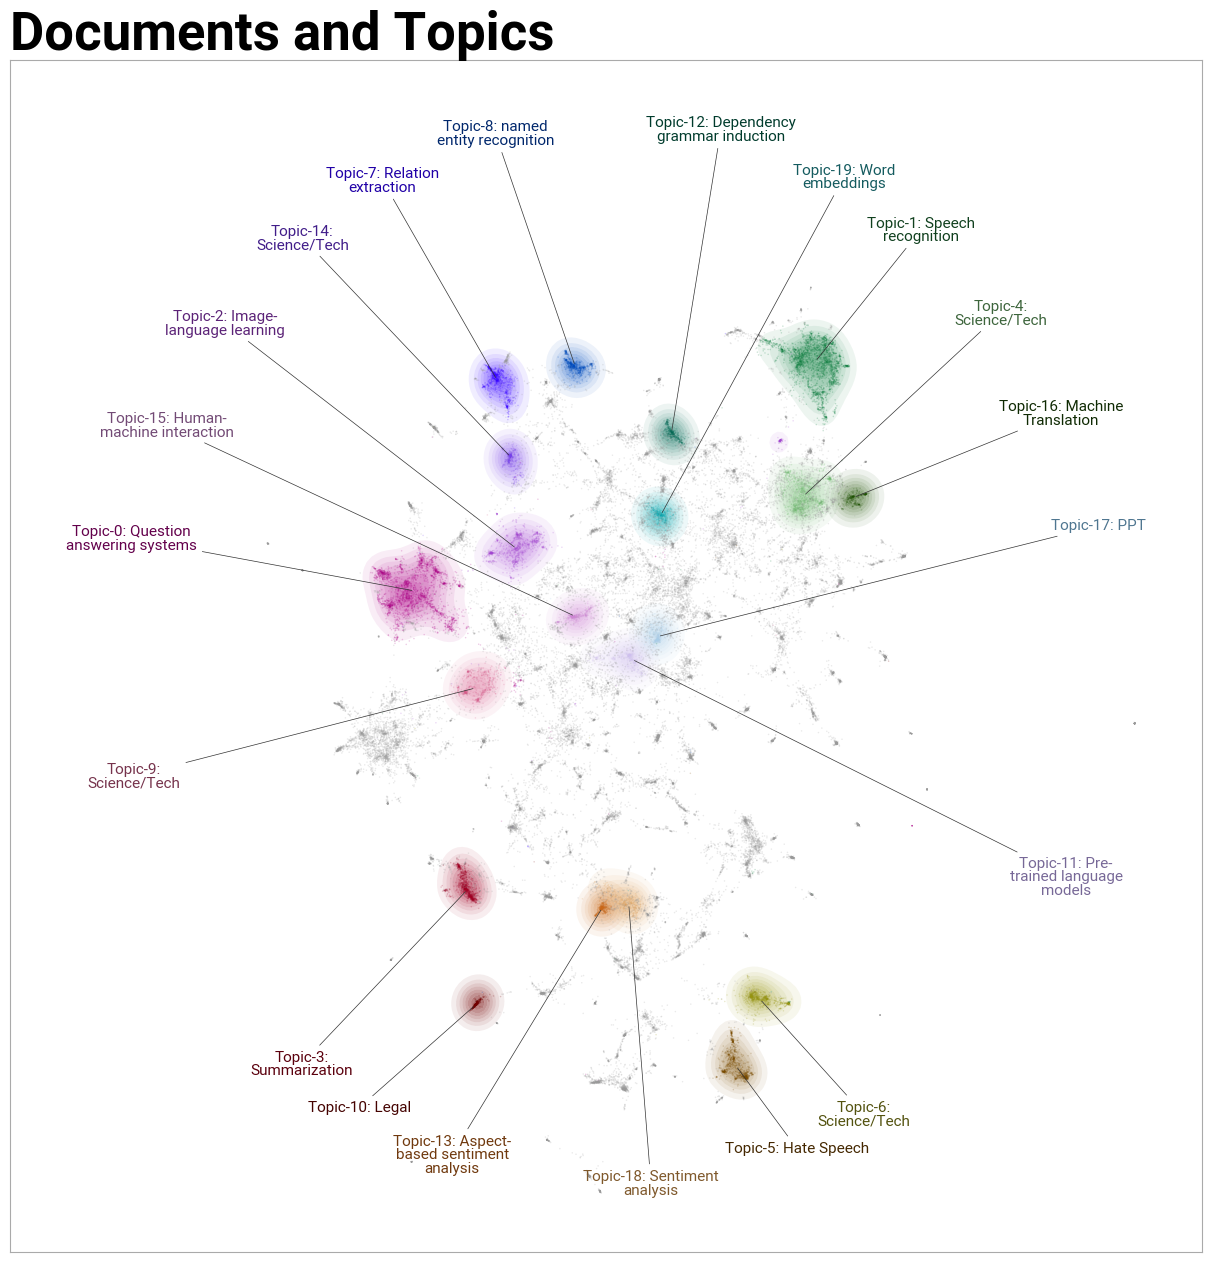

In [30]:
# Visualize topics and documents
fig = topic_model.visualize_document_datamap(
    titles,
    topics=list(range(20)),
    reduced_embeddings=embeddings_2d, #reduced_embeddings,
    width=1200,
    label_font_size=11,
    label_wrap_width=20,
    use_medoids=True,
)

  0%|          | 0/500 [00:00<?, ?it/s]

Resetting positions to accord with alignment


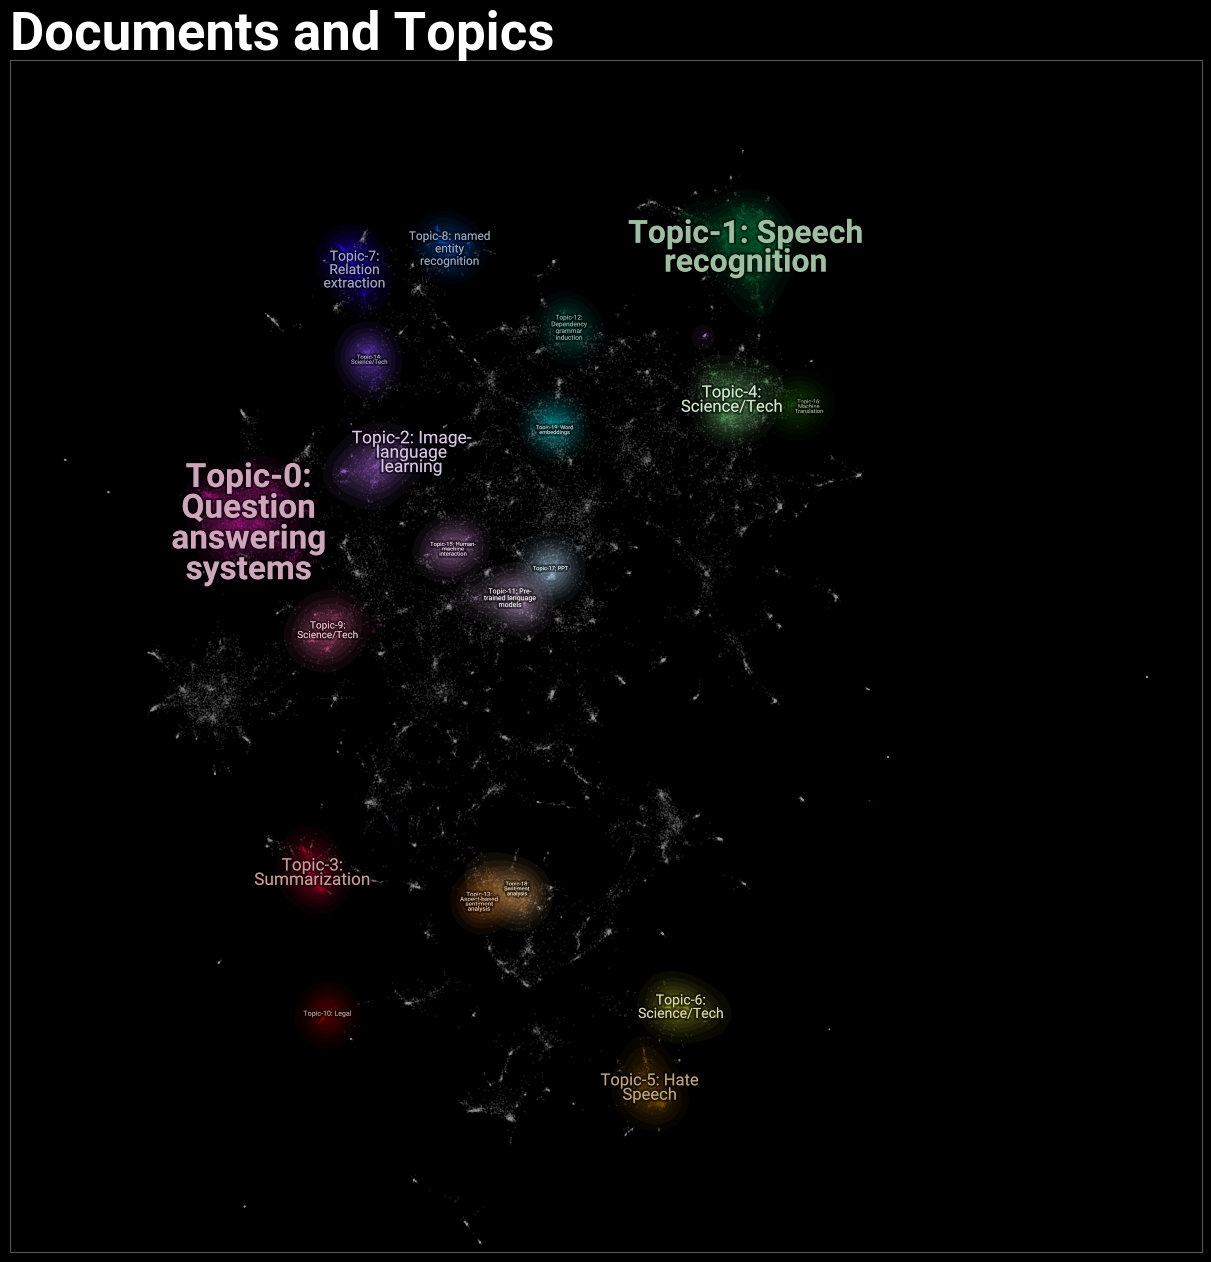

In [33]:
# Dark mode - but same data as above to visualize topics and documents
fig = topic_model.visualize_document_datamap(
    titles,
    topics=list(range(20)),
    reduced_embeddings=embeddings_2d, #reduced_embeddings,
    width=1200,
    # label_font_size=11,
    # label_wrap_width=20,
    # use_medoids=True,
    label_over_points=True,
    dynamic_label_size=True,
    dynamic_label_size_scaling_factor=0.5,
    # color_label_text=False,
    darkmode=True,
)